In [1]:
import sys
sys.path.insert(0, "..")

import jax
import jax.numpy as jnp

import flax.linen as nn

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Hydrogen Atom

In this notebook we demonstrate a VMC method for finding the ground state of the hydrogen atom:

$$
H = -\frac{\hbar^2 }{2 m}\Delta - \frac{e^2}{4\pi\epsilon_0 r}
$$

The corresponding energies are known:
$$
E = -\frac{1}{n^2}\frac{m e^4}{32\pi^2\epsilon_{0}^2\hbar^2}
$$

We set $\hbar = m = 1$ and $e^4 = 32 \pi^2 \epsilon_{0}^2$. The ground state energy is thus:

$$
E = -1
$$

In the code, the hamiltonian is defined as follows:

In [3]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

We use a Neural Network variational Ansatz.

In [4]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

In [72]:
class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x + 1)
        x = nn.Dense(1)(x)
        x = nn.sigmoid(x)
        return jnp.squeeze(x)

In [73]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))
        self.net = NN()

    def init_parameters(self, key):
        return self.net.init(key, jnp.empty(3))

    def calc_logpsi(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2, axis = -1))
        return self.net.apply(parameters, x)*15 - r/5

In [74]:
wavefun = Orbital()
key, _ = jax.random.split(key)
parameters = wavefun.init_parameters(key)

In [75]:
parameters

{'params': {'Dense_0': {'kernel': Array([[ 1.07739830e+00,  2.65074313e-01, -4.72608171e-02,
           -6.66547000e-01, -6.39913440e-01,  4.85917091e-01,
           -1.33017331e-01,  4.30147380e-01, -3.89654100e-01,
            1.11928180e-01,  5.36567330e-01, -2.58468807e-01,
           -4.00471807e-01, -1.56363234e-01,  2.49432191e-01,
           -8.73631120e-01, -3.82110357e-01, -2.67274469e-01,
            3.19184124e-01, -3.80737484e-01, -2.03922868e-01,
            2.84682900e-01,  8.30396414e-01, -9.42788184e-01,
           -7.74057657e-02,  5.10082394e-03,  4.14544433e-01,
           -4.69261706e-02,  9.68007743e-01,  1.68395445e-01,
            6.47281170e-01, -5.56144826e-02, -1.47050425e-01,
            5.68503141e-01,  6.75650954e-01, -7.10196674e-01,
            7.19884038e-01,  6.58352494e-01, -9.06872898e-02,
            1.00412786e-01, -4.86420751e-01, -5.70040286e-01,
            1.21185541e+00, -2.41893977e-01,  6.36304140e-01,
           -1.08494258e+00, -2.49771863

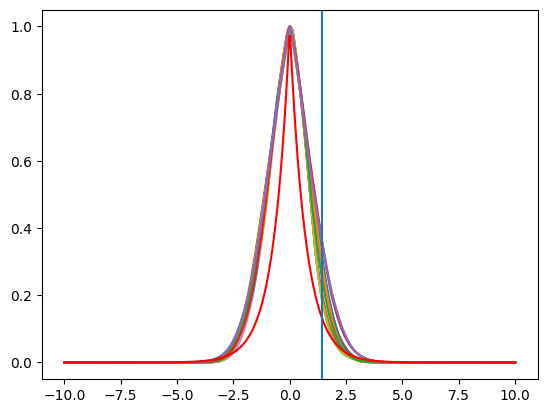

In [101]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)))


s = np.linspace(-10, 10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red")
# plt.yscale("log")

plt.axvline(jnp.sqrt(2))
# plt.xlim(-5, 5)
# plt.xlim(jnp.sqrt(2)-1, jnp.sqrt(2)+1)


In [102]:
class sOrbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

    def calc_logpsi(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2, axis = -1))
        return -jnp.sqrt(2)*r

In [132]:
sorbital = sOrbital()
s_sampler = module.samplers.MCMC(sorbital, variance=0.1)

s_samples, ratio = s_sampler.sample(key, None, jax.random.normal(key, (3,)), 4000)

We also initialise a MCMC sampler for our wavefunction and can take samples of it:

In [104]:
sampler = module.samplers.MCMC(wavefun, variance = 0.1)

Using the Hamiltonian, we can already compute the expected energy for our non-optimised wavefunction:

In [129]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 2000)
key, _ = jax.random.split(key)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.71050006
Expected Energy: -1.5359517
Std of Expected Energy: 0.82464886


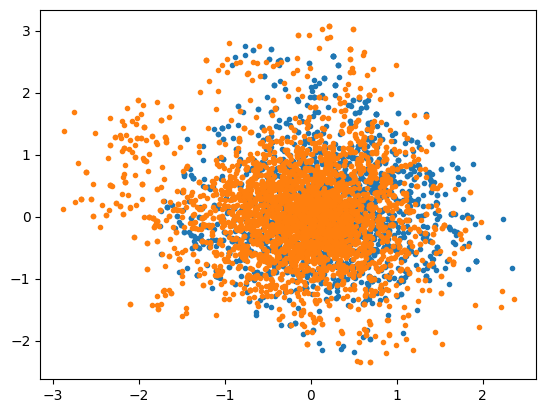

In [133]:
plt.scatter(samples[:,0], samples[:, 1], marker = ".")
plt.scatter(s_samples[:,0], s_samples[:, 1], marker = ".")

To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [83]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [93]:
Es = []
dEs = []
ratios = []

# define
optimizer = optax.adam(learning_rate = 0.001)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(50)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es.append(E)
    dEs.append(dE)
    ratios.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es)
dEs = np.array(dEs) / jnp.sqrt(6000)
ratios = np.array(ratios)

100%|██████████| 50/50 [00:01<00:00, 25.18it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Energy Optimisation')

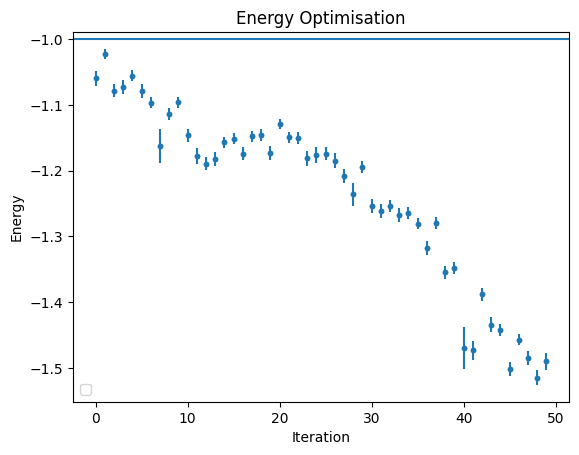

In [94]:
plt.scatter(np.arange(Es.shape[0]), Es, marker = ".")
plt.errorbar(np.arange(Es.shape[0]), Es, dEs, fmt = ".")

plt.axhline(-1)

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

In [95]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.18429999
Expected Energy: -1.5569956
Std of Expected Energy: 0.83900166


---